In [1]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set seeds
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import json
import pandas as pd
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Fetching PCP properties of druggable and non-druggable proteins
data_file_path = "/content/drive/MyDrive/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/druggable_proteins.txt"
approved_druggable_proteins_file_path = "/content/drive/MyDrive/approved_druggable_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))

with open(druggable_proteins_file_path, 'r') as f:
    druggable_proteins = f.read().splitlines()

with open(approved_druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of approved druggable proteins:", len(approved_druggable_proteins))

properties = (pd.read_json("/content/drive/MyDrive/protein_props.json")).transpose()
is_druggable = [1 if i in druggable_proteins else 0 for i in properties.index]
is_approved_druggable = [1 if i in approved_druggable_proteins else 0 for i in properties.index]

properties["is_druggable"] = is_druggable
properties["is_approved_druggable"] = is_approved_druggable

PCP_properties = properties.copy()
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_acid_percent = {i:[] for i in amino_acids}
for i in PCP_properties['Amino Acid Percent']:
  for aa in amino_acids:
    amino_acid_percent[aa].append(i[aa])
for aa in amino_acids:
  PCP_properties = pd.concat([PCP_properties, pd.Series(amino_acid_percent[aa], index = PCP_properties.index, name = f"Amino Acid Percent {aa}")], axis = 1)

PCP_properties[f"Molar Extinction Coefficient 1"] = pd.Series([x[0] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)
PCP_properties[f"Molar Extinction Coefficient 2"] = pd.Series([x[1] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)

PCP_properties[f"Secondary Structure helix"] = pd.Series([x[0] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure turn"] = pd.Series([x[1] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure sheet"] = pd.Series([x[2] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)

PCP_properties.drop(columns = ['Amino Acid Count','Amino Acid Percent',"Molar Extinction Coefficient","Flexibility","Secondary Structure",'Sequence'], inplace = True)
PCP_properties['Sequence Length'] = PCP_properties['Sequence Length'].astype(int)
PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']] = PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']].astype(float)

with open("/content/drive/MyDrive/BDDF_Research/gdpc_encodings.json", 'r') as file:
    data = json.load(file)
gpdc_encodings = pd.DataFrame(data).transpose()

ppi = pd.read_json("/content/drive/MyDrive/ppi.json").transpose()
ppi_network = pd.read_csv("/content/drive/MyDrive/BDDF_Research/ppi_network_properties.csv")
ppi_network.index = ppi_network['Unnamed: 0']
ppi_network.drop(columns = ['Unnamed: 0'], inplace = True)
ppi = pd.concat([ppi, ppi_network], axis = 1)

glycolisation = pd.read_csv("/content/drive/MyDrive/glycosylation.csv")
glycolisation.index = glycolisation['Unnamed: 0']
glycolisation.drop(columns = ['Unnamed: 0'], inplace = True)
ptm = pd.read_csv("/content/drive/MyDrive/PTM_counts.csv")
ptm.index = ptm["Unnamed: 0"]
ptm.drop(columns = ['Unnamed: 0'], inplace = True)
ptm_counts = pd.concat([ptm, glycolisation], axis = 1)

with open("/content/drive/MyDrive/subcellular_locations2.json", 'r') as file:
    data = json.load(file)
unique_groups = set()
for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry: unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

rows = []
for protein_id in PCP_properties.index:
    row = {group: 0 for group in unique_groups_list}
    if protein_id in data:
        for entry in data[protein_id].get("general", []):
            if "group" in entry and entry["group"] in unique_groups:
                row[entry["group"]] = 1
    row["protein_id"] = protein_id
    rows.append(row)

subcellular_data = pd.DataFrame(rows).set_index("protein_id")

domains = pd.read_csv("/content/drive/MyDrive/BDDF_Research/data_top20_updated.csv")
domains.index = domains['Unnamed: 0']
domains.drop(columns = ['Unnamed: 0'], inplace = True)

flexibility = pd.read_csv("/content/drive/MyDrive/BDDF_Research/flexibility_properties.csv")
flexibility.index = flexibility['Unnamed: 0']
flexibility.drop(columns = ['Unnamed: 0'], inplace = True)

latent_data = pd.read_csv("/content/drive/MyDrive/BDDF_Research/latent_values.csv").transpose()
latent_data.columns = [f"Latent_Value_{i+1}" for i in latent_data.columns]
final_data = pd.concat([PCP_properties,gpdc_encodings, ptm_counts, ppi, subcellular_data, domains, flexibility, latent_data], axis = 1).dropna()
features_list = final_data.columns
features_list = features_list.drop(['is_druggable','is_approved_druggable'])
features_list = list(features_list)
print(features_list)
print(len(features_list))

Total number of uniprot human verified proteins: 20434
Number of druggable proteins: 3345
Number of approved druggable proteins: 2652
['Sequence Length', 'Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7', 'Amino Acid Percent A', 'Amino Acid Percent C', 'Amino Acid Percent D', 'Amino Acid Percent E', 'Amino Acid Percent F', 'Amino Acid Percent G', 'Amino Acid Percent H', 'Amino Acid Percent I', 'Amino Acid Percent K', 'Amino Acid Percent L', 'Amino Acid Percent M', 'Amino Acid Percent N', 'Amino Acid Percent P', 'Amino Acid Percent Q', 'Amino Acid Percent R', 'Amino Acid Percent S', 'Amino Acid Percent T', 'Amino Acid Percent V', 'Amino Acid Percent W', 'Amino Acid Percent Y', 'Molar Extinction Coefficient 1', 'Molar Extinction Coefficient 2', 'Secondary Structure helix', 'Secondary Structure turn', 'Secondary Structure sheet', 'aliphatic_aliphatic', 'aliphatic_positive', 'aliphatic_negative', 'aliphatic_uncharged', 'aliphatic_aromatic',

In [5]:
PCP_data = final_data[PCP_properties.columns]
gpdc_data = final_data[gpdc_encodings.columns]
ptm_data = final_data[ptm_counts.columns]
ppi_data = final_data[ppi.columns]
subcellular_data = final_data[subcellular_data.columns]
domains_data = final_data[domains.columns]
flexibility_data = final_data[flexibility.columns]
latent_data = final_data[latent_data.columns]

In [6]:
#for splitting of data
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE

def get_data(x_sample, y_sample):
  return np.array(x_sample), np.array(y_sample)

def data_splitting(x_sample, y_sample, mode="default", scaler="none", class_size=600):
  druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
  non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

  druggable_X = x_sample[druggable_indices]
  druggable_y = y_sample[druggable_indices]

  non_druggable_X = x_sample[non_druggable_indices]
  non_druggable_y = y_sample[non_druggable_indices]

  druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
  non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size= class_size, random_state=123)

  X_test = pd.concat((druggable_X_test, non_druggable_X_test))
  y_test = pd.concat((druggable_y_test, non_druggable_y_test))
  X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
  y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))
  X_train, y_train = shuffle(X_train, y_train, random_state=123)
  if mode == "default":
    pass
  elif mode == "adasyn":
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_resample(X_train, y_train)
  elif mode == "smote":
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_resample(X_train, y_train)

  if scaler == "std":
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "minmax":
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "none":
    pass

  return X_train, X_test, y_train, y_test

In [7]:
X_train_PCP, X_test_PCP, y_train_PCP, y_test_PCP = data_splitting(PCP_data, final_data["is_druggable"],mode = "scaler", class_size=600)
X_train_gpdc, X_test_gpdc, y_train_gpdc, y_test_gpdc = data_splitting(gpdc_data, final_data["is_druggable"],mode = "scaler", class_size=600)
X_train_ptm, X_test_ptm, y_train_ptm, y_test_ptm = data_splitting(ptm_data, final_data["is_druggable"],mode = "scaler", class_size=600)
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = data_splitting(PCP_data, final_data["is_druggable"],mode = "scaler", class_size=600)
X_train_subcellular, X_test_subcellular, y_train_subcellular, y_test_subcellular = data_splitting(subcellular_data, final_data["is_druggable"],mode = "scaler", class_size=600)
X_train_domains, X_test_domains, y_train_domains, y_test_domains = data_splitting(domains_data, final_data["is_druggable"],mode = "scaler", class_size=600)
X_train_flexibility, X_test_flexibility, y_train_flexibility, y_test_flexibility = data_splitting(flexibility_data, final_data["is_druggable"],mode = "scaler", class_size=600)
X_train_latent, X_test_latent, y_train_latent, y_test_latent = data_splitting(latent_data, final_data["is_druggable"],mode = "scaler", class_size=600)

# X_train_PCP.shape, X_test_PCP.shape, y_train_PCP.shape, y_test_PCP.shape

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.svm as svm
import xgboost as xgb


def analysis_pipeline(X_train_PCP, y_train_PCP, X_test_PCP, y_test_PCP):

      X_train_PCP_druggable = X_train_PCP[y_train_PCP == 1]
      X_train_PCP_non_druggable = X_train_PCP[y_train_PCP == 0]

      X_train_PCP_non_druggable_partitions = np.array_split(X_train_PCP_non_druggable, int(len(X_train_PCP_non_druggable)/len(X_train_PCP_druggable)))
      print(f"Splitting into {len(X_train_PCP_non_druggable_partitions)} partitions")

      logistic_PCP_models = []
      xgb_PCP_models = []
      Random_Forest_PCP_models = []

      for partition in X_train_PCP_non_druggable_partitions:
        X_combined = np.concatenate((X_train_PCP_druggable, partition))
        y_combined = np.concatenate((np.ones(len(X_train_PCP_druggable)), np.zeros(len(partition))))
        xgb_model = xgb.XGBClassifier(alpha = 500,random_state= 42)
        xgb_model.fit(X_combined, y_combined)
        xgb_PCP_models.append(xgb_model)

      for partition in X_train_PCP_non_druggable_partitions:
        X_combined = np.concatenate((X_train_PCP_druggable, partition))
        y_combined = np.concatenate((np.ones(len(X_train_PCP_druggable)), np.zeros(len(partition))))
        logistic_model = LogisticRegression(penalty = "l2", random_state= 42)
        logistic_model.fit(X_combined, y_combined)
        logistic_PCP_models.append(logistic_model)

      for partition in X_train_PCP_non_druggable_partitions:
        X_combined = np.concatenate((X_train_PCP_druggable, partition))
        y_combined = np.concatenate((np.ones(len(X_train_PCP_druggable)), np.zeros(len(partition))))
        rf_model = RandomForestClassifier(
          n_estimators=800,        # Number of trees
          max_depth=10,            # Maximum depth of each tree
          min_samples_split=5,     # Minimum samples required to split a node
          min_samples_leaf=4,      # Minimum samples required at a leaf node
          max_features='sqrt',     # Number of features to consider at each split
          bootstrap=True,          # Use bootstrap samples
          random_state=42          # For reproducibility
      )
        rf_model.fit(X_combined, y_combined)
        Random_Forest_PCP_models.append(rf_model)

      y_preds_xgboost = []
      for model in xgb_PCP_models:
        y_pred = model.predict(X_test_PCP)
        y_preds_xgboost.append(y_pred)

      majority_preds_xgboost = np.mean(y_preds_xgboost, axis=0)
      majority_preds_xgboost = np.round(majority_preds_xgboost)

      y_preds_logistic = []
      for model in logistic_PCP_models:
        y_pred = model.predict(X_test_PCP)
        y_preds_logistic.append(y_pred)

      majority_preds_logistic = np.mean(y_preds_logistic, axis=0)
      majority_preds_logistic = np.round(majority_preds_logistic)

      y_preds_rf = []
      for model in Random_Forest_PCP_models:
        y_pred = model.predict(X_test_PCP)
        y_preds_rf.append(y_pred)

      majority_preds_rf = np.mean(y_preds_rf, axis=0)
      majority_preds_rf = np.round(majority_preds_rf)

      from sklearn.metrics import accuracy_score
      accuracy_metrics = {}
      for i, y_pred in enumerate(y_preds_xgboost):
        accuracy_metrics[f"partition_{i}"]={
            "accuracy_total": accuracy_score(y_test_PCP, y_pred),
            "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], y_pred[y_test_PCP == 1]),
            "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], y_pred[y_test_PCP == 0]),
        }

      accuracy_metrics["majority"] = {
          "accuracy_total": accuracy_score(y_test_PCP, majority_preds_xgboost),
          "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], majority_preds_xgboost[y_test_PCP == 1]),
          "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], majority_preds_xgboost[y_test_PCP == 0]),
      }

      xgboost = pd.DataFrame(accuracy_metrics).transpose()

      from sklearn.metrics import accuracy_score
      accuracy_metrics = {}
      for i, y_pred in enumerate(y_preds_logistic):
        accuracy_metrics[f"partition_{i}"]={
            "accuracy_total": accuracy_score(y_test_PCP, y_pred),
            "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], y_pred[y_test_PCP == 1]),
            "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], y_pred[y_test_PCP == 0]),
        }

      accuracy_metrics["majority"] = {
          "accuracy_total": accuracy_score(y_test_PCP, majority_preds_logistic),
          "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], majority_preds_logistic[y_test_PCP == 1]),
          "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], majority_preds_logistic[y_test_PCP == 0]),
      }

      logistic = pd.DataFrame(accuracy_metrics).transpose()

      from sklearn.metrics import accuracy_score
      accuracy_metrics = {}
      for i, y_pred in enumerate(y_preds_rf):
        accuracy_metrics[f"partition_{i}"]={
            "accuracy_total": accuracy_score(y_test_PCP, y_pred),
            "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], y_pred[y_test_PCP == 1]),
            "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], y_pred[y_test_PCP == 0]),
        }

      accuracy_metrics["majority"] = {
          "accuracy_total": accuracy_score(y_test_PCP, majority_preds_rf),
          "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], majority_preds_rf[y_test_PCP == 1]),
          "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], majority_preds_rf[y_test_PCP == 0]),
      }

      random_forest = pd.DataFrame(accuracy_metrics).transpose()
      return logistic_PCP_models, xgb_PCP_models, Random_Forest_PCP_models, xgboost, logistic, random_forest

logistic_PCP_models, xgb_PCP_models, Random_Forest_PCP_models, xgboost, logistic, random_forest = analysis_pipeline(X_train_PCP, y_train_PCP, X_test_PCP, y_test_PCP)

In [28]:
logistic_gpdc_models, xgb_gpdc_models, Random_Forest_gpdc_models, xgboost_gpdc, logistic_gpdc, random_forest_gpdc = analysis_pipeline(X_train_gpdc, y_train_gpdc, X_test_gpdc, y_test_gpdc)
logistic_ppi_models, xgb_ppi_models, Random_Forest_ppi_models, xgboost_ppi, logistic_ppi, random_forest_ppi = analysis_pipeline(X_train_ppi, y_train_ppi, X_test_ppi, y_test_ppi)
logistic_ptm_models, xgb_ptm_models, Random_Forest_ptm_models, xgboost_ptm, logistic_ptm, random_forest_ptm = analysis_pipeline(X_train_ptm, y_train_ptm, X_test_ptm, y_test_ptm)
logistic_subcellular_models, xgb_subcellular_models, Random_Forest_subcellular_models, xgboost_subcellular, logistic_subcellular, random_forest_subcellular = analysis_pipeline(X_train_subcellular, y_train_subcellular, X_test_subcellular, y_test_subcellular)
logistic_domains_models, xgb_domains_models, Random_Forest_domains_models, xgboost_domains, logistic_domains, random_forest_domains = analysis_pipeline(X_train_domains, y_train_domains, X_test_domains, y_test_domains)
logistic_flexibility_models, xgb_flexibility_models, Random_Forest_flexibility_models, xgboost_flexibility, logistic_flexibility, random_forest_flexibility = analysis_pipeline(X_train_flexibility, y_train_flexibility, X_test_flexibility, y_test_flexibility)
logistic_domains_models, xgb_domains_models, Random_Forest_domains_models, xgboost_domains, logistic_domains, random_forest_domains = analysis_pipeline(X_train_domains, y_train_domains, X_test_domains, y_test_domains)
logistic_latent_models, xgb_latent_models, Random_Forest_latent_models, xgboost_latent, logistic_latent, random_forest_latent = analysis_pipeline(X_train_latent, y_train_latent, X_test_latent, y_test_latent)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warning

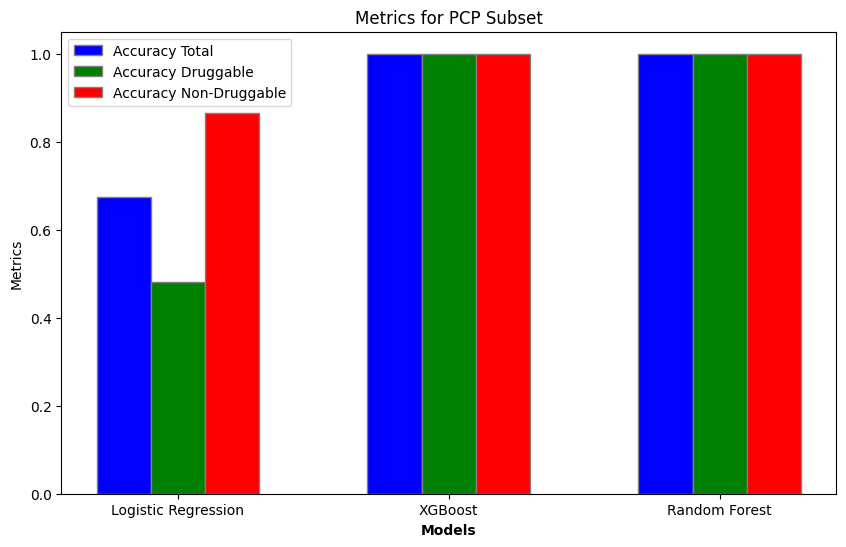

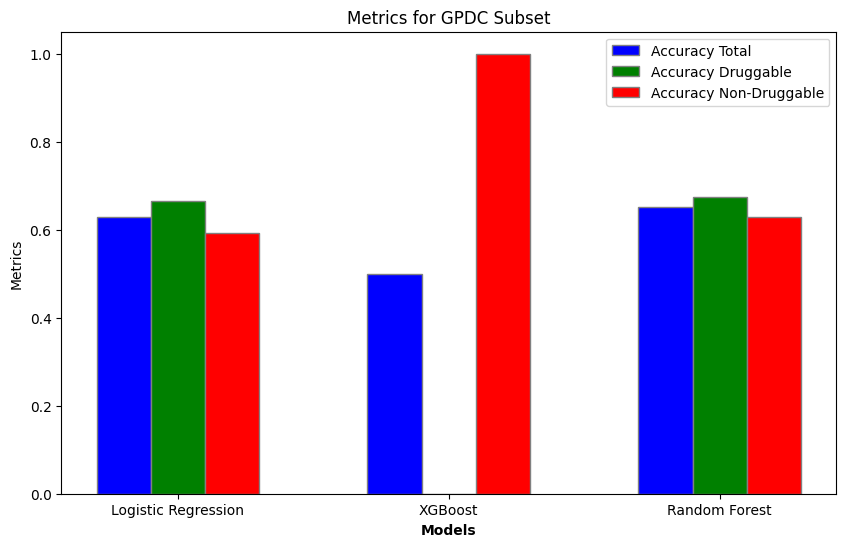

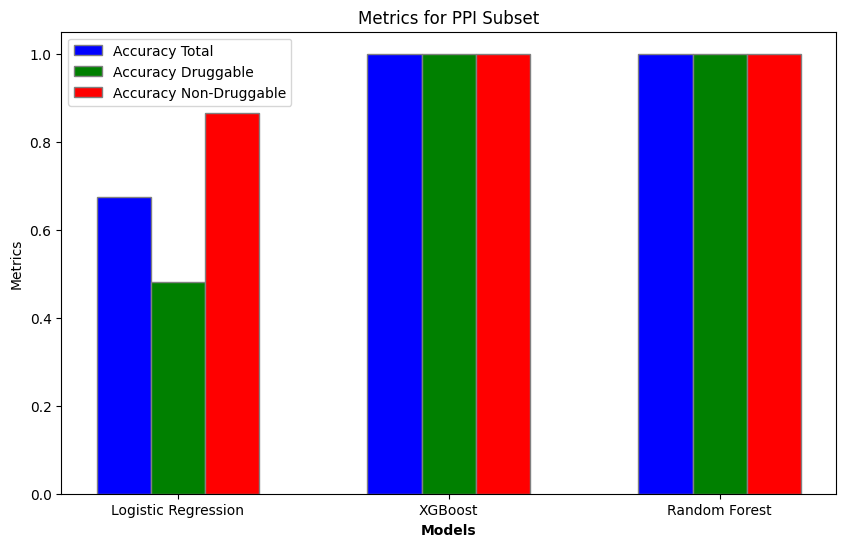

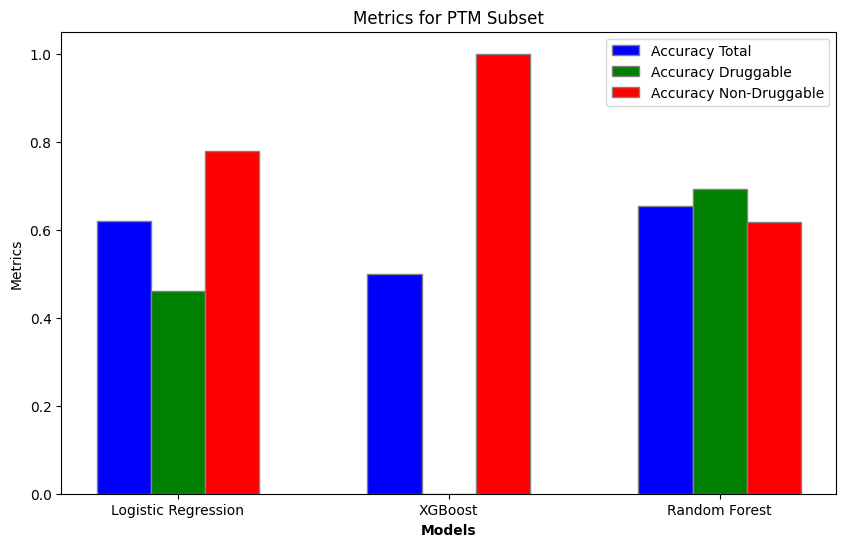

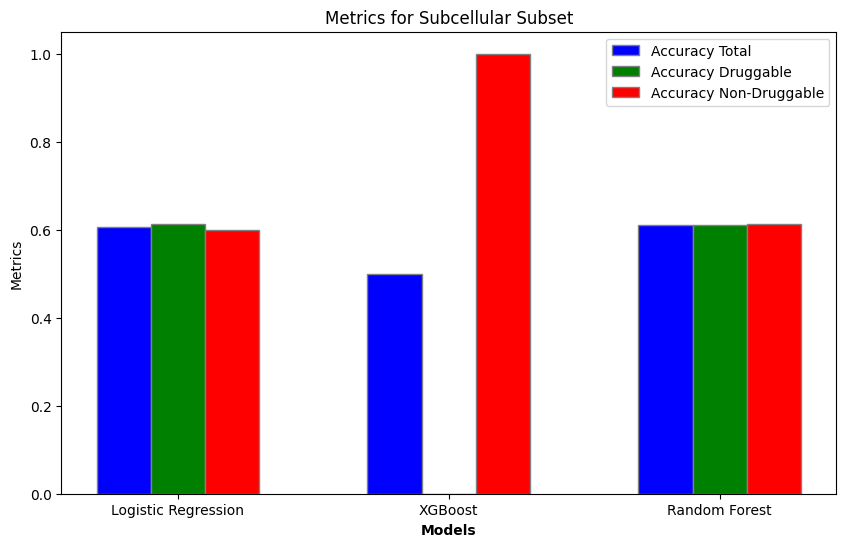

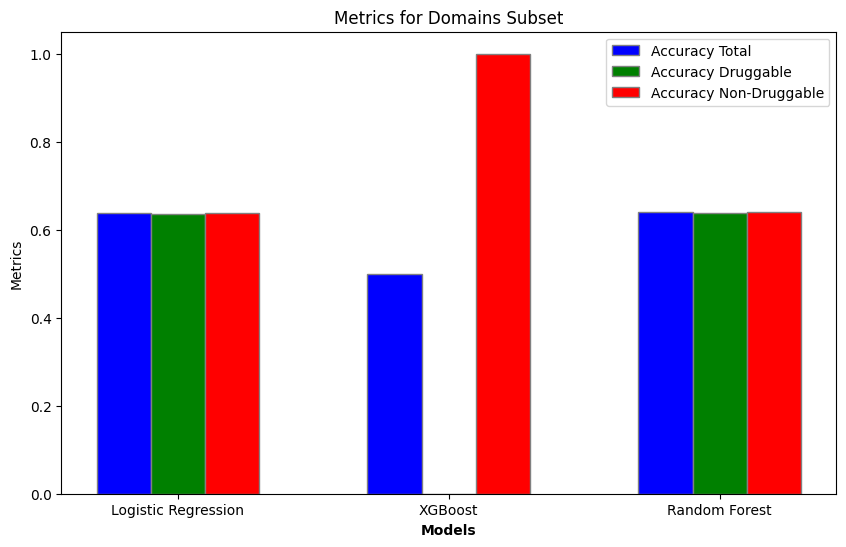

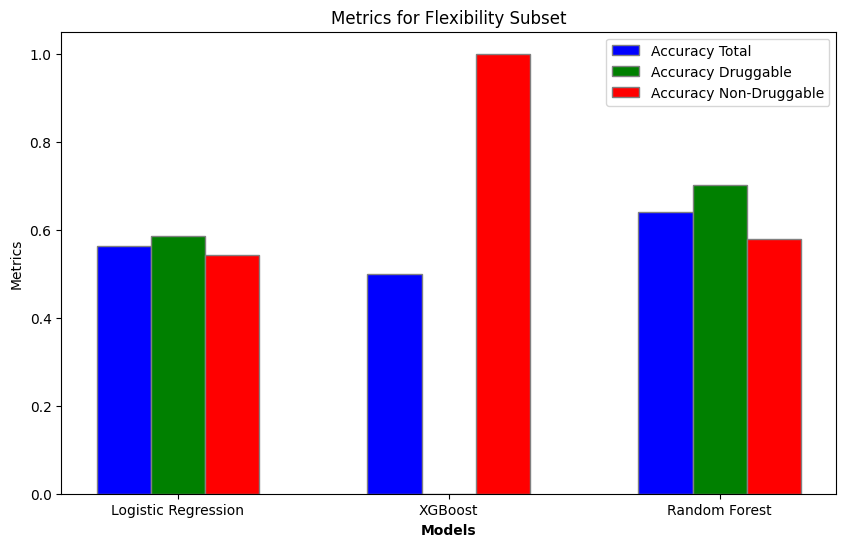

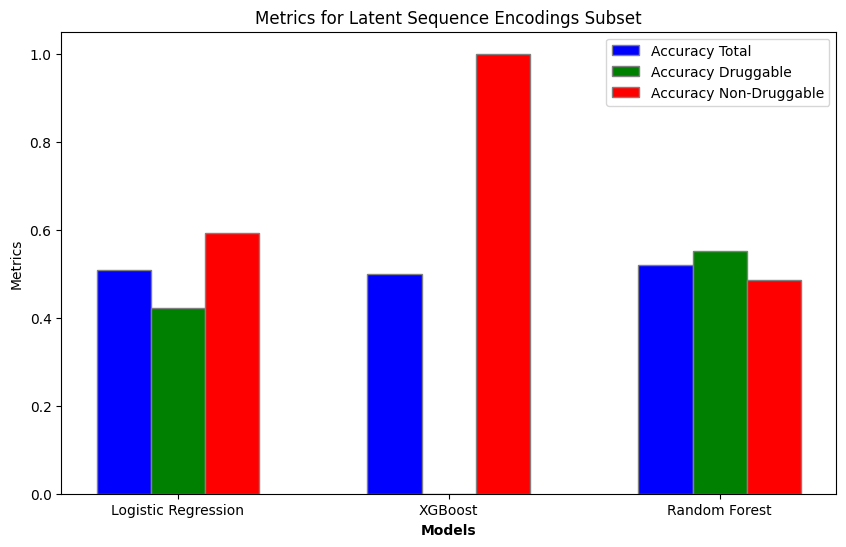

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Example of how to access metrics for each model and subset
# Replace these with your actual data structures
metrics_data = {
    'PCP': {
        'Logistic Regression': list(logistic.loc['majority']),
        'XGBoost': list(xgboost.loc['majority']),
        'Random Forest': list(random_forest.loc['majority']),
    },
    'GPDC': {
        'Logistic Regression': list(logistic_gpdc.loc['majority']),
        'XGBoost': list(xgboost_gpdc.loc['majority']),
        'Random Forest': list(random_forest_gpdc.loc['majority']),
    },
    'PPI': {
        'Logistic Regression': list(logistic_ppi.loc['majority']),
        'XGBoost': list(xgboost_ppi.loc['majority']),
        'Random Forest': list(random_forest_ppi.loc['majority']),
    },
    'PTM': {
        'Logistic Regression': list(logistic_ptm.loc['majority']),
        'XGBoost': list(xgboost_ptm.loc['majority']),
        'Random Forest': list(random_forest_ptm.loc['majority']),
    },
    'Subcellular': {
        'Logistic Regression': list(logistic_subcellular.loc['majority']),
        'XGBoost': list(xgboost_subcellular.loc['majority']),
        'Random Forest': list(random_forest_subcellular.loc['majority']),
    },
    'Domains': {
        'Logistic Regression': list(logistic_domains.loc['majority']),
        'XGBoost': list(xgboost_domains.loc['majority']),
        'Random Forest': list(random_forest_domains.loc['majority']),
    },
    'Flexibility': {
        'Logistic Regression': list(logistic_flexibility.loc['majority']),
        'XGBoost': list(xgboost_flexibility.loc['majority']),
        'Random Forest': list(random_forest_flexibility.loc['majority']),
    },
    'Latent Sequence Encodings': {
        'Logistic Regression': list(logistic_latent.loc['majority']),
        'XGBoost': list(xgboost_latent.loc['majority']),
        'Random Forest': list(random_forest_latent.loc['majority']),
    }
}

# Plotting for each data subset
for subset, models_metrics in metrics_data.items():
    # Create a new figure for each subset
    plt.figure(figsize=(10, 6))

    # Set the positions of the bars on the x-axis
    bar_width = 0.2
    r1 = np.arange(len(models_metrics))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Extract metrics for each model
    accuracy_total = [metrics[0] for metrics in models_metrics.values()]
    accuracy_druggable = [metrics[1] for metrics in models_metrics.values()]
    accuracy_non_druggable = [metrics[2] for metrics in models_metrics.values()]

    # Create bar plots for each metric
    plt.bar(r1, accuracy_total, color='blue', width=bar_width, edgecolor='grey', label='Accuracy Total')
    plt.bar(r2, accuracy_druggable, color='green', width=bar_width, edgecolor='grey', label='Accuracy Druggable')
    plt.bar(r3, accuracy_non_druggable, color='red', width=bar_width, edgecolor='grey', label='Accuracy Non-Druggable')

    # Add labels and titles
    plt.xlabel('Models', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(models_metrics))], models_metrics.keys())
    plt.ylabel('Metrics')
    plt.title(f'Metrics for {subset} Subset')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [ ]:
#ensembline pipeline using uniform majority voting mechanism
from sklearn.metrics import accuracy_score
#like for PCP dataset
y_preds_PCP = []
for model in xgb_PCP_models:
    y_pred = model.predict(X_test_PCP)
    y_preds_PCP.append(y_pred)

majority_preds_PCP = np.mean(y_preds_PCP, axis=0)
majority_preds_PCP = np.round(majority_preds_PCP)

#like for GPDC dataset
y_preds_gpdc = []
for model in Random_Forest_gpdc_models:
    y_pred = model.predict(X_test_gpdc)
    y_preds_gpdc.append(y_pred)

majority_preds_gpdc = np.mean(y_preds_gpdc, axis=0)
majority_preds_gpdc = np.round(majority_preds_gpdc)

#like for PPI dataset
y_preds_ppi = []
for model in xgb_ppi_models:
    y_pred = model.predict(X_test_ppi)
    y_preds_ppi.append(y_pred)

majority_preds_ppi = np.mean(y_preds_ppi, axis=0)
majority_preds_ppi = np.round(majority_preds_ppi)

#like for PTM dataset
y_preds_ptm = []
for model in Random_Forest_ptm_models:
    y_pred = model.predict(X_test_ptm)
    y_preds_ptm.append(y_pred)

majority_preds_ptm = np.mean(y_preds_ptm, axis=0)
majority_preds_ptm = np.round(majority_preds_ptm)

#like for Subcellular dataset
y_preds_subcellular = []
for model in logistic_subcellular_models:
    y_pred = model.predict(X_test_subcellular)
    y_preds_subcellular.append(y_pred)

majority_preds_subcellular = np.mean(y_preds_subcellular, axis=0)
majority_preds_subcellular = np.round(majority_preds_subcellular)

#like for Domains dataset
y_preds_domains = []
for model in logistic_domains_models:
    y_pred = model.predict(X_test_domains)
    y_preds_domains.append(y_pred)

majority_preds_domains = np.mean(y_preds_domains, axis=0)
majority_preds_domains = np.round(majority_preds_domains)

#like for Flexibility dataset
y_preds_flexibility = []
for model in Random_Forest_flexibility_models:
    y_pred = model.predict(X_test_flexibility)
    y_preds_flexibility.append(y_pred)

majority_preds_flexibility = np.mean(y_preds_flexibility, axis=0)
majority_preds_flexibility = np.round(majority_preds_flexibility)

#like for latent dataset
y_preds_latent = []
for model in Random_Forest_latent_models:
    y_pred = model.predict(X_test_latent)
    y_preds_latent.append(y_pred)

majority_preds_latent = np.mean(y_preds_latent, axis=0)
majority_preds_latent = np.round(majority_preds_latent)

# Combining all majority vote predictions
all_majority_preds = np.array([
    majority_preds_PCP,
    majority_preds_gpdc,
    majority_preds_ppi,
    majority_preds_ptm,
    majority_preds_subcellular,
    majority_preds_domains,
    majority_preds_flexibility,
    majority_preds_latent
])

metrics_label = np.array([
    "PCP XgBoost",
    "GPDC Encodings Random Forest",
    "PPI XgBoost",
    "PTM Random Forest",
    "Subcellular logistic Regression",
    "Domains logistic Regression",
    "Flexibility Random Forest",
    "Latent Random Forest"
])

# Perform final majority voting across all data subsets
final_majority_preds = np.mean(all_majority_preds, axis=0)
final_majority_preds = np.round(final_majority_preds)

from sklearn.metrics import accuracy_score
accuracy_metrics = {}
for i, y_pred in enumerate(all_majority_preds):
  accuracy_metrics[metrics_label[i]]={
      "accuracy_total": accuracy_score(y_test_PCP, y_pred),
      "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], y_pred[y_test_PCP == 1]),
      "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], y_pred[y_test_PCP == 0]),
  }

accuracy_metrics["majority"] = {
    "accuracy_total": accuracy_score(y_test_PCP, final_majority_preds),
    "accuracy_druggable": accuracy_score(y_test_PCP[y_test_PCP == 1], final_majority_preds[y_test_PCP == 1]),
    "accuracy_non_druggable": accuracy_score(y_test_PCP[y_test_PCP == 0], final_majority_preds[y_test_PCP == 0]),
}

final_metrics = pd.DataFrame(accuracy_metrics).transpose()

In [47]:
final_metrics

,accuracy_total,accuracy_druggable,accuracy_non_druggable
PCP XgBoost,1.000000,1.000000,1.000000
GPDC Encodings Random Forest,0.650833,0.673333,0.628333
PPI XgBoost,1.000000,1.000000,1.000000
PTM Random Forest,0.655000,0.693333,0.616667
Subcellular logistic Regression,0.605833,0.613333,0.598333
Domains logistic Regression,0.637500,0.636667,0.638333
Flexibility Random Forest,0.640000,0.701667,0.578333
Latent Random Forest,0.519167,0.551667,0.486667
majority,0.869167,0.836667,0.901667


Confusion Matrix:
[[541  59]
 [ 98 502]]


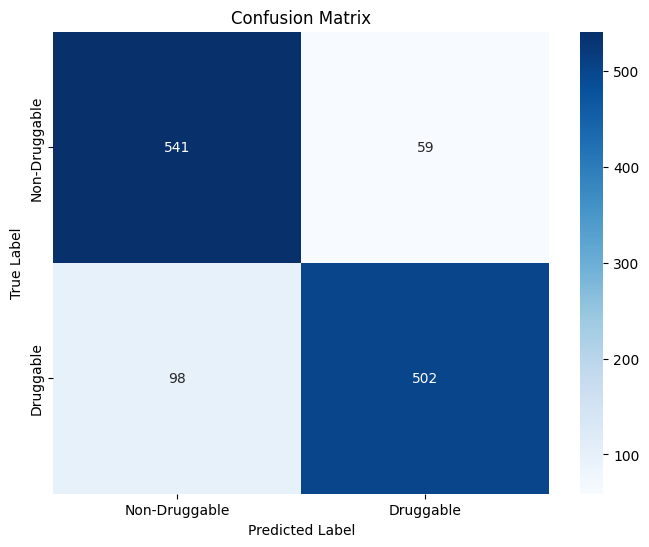

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_PCP, final_majority_preds)

print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Druggable', 'Druggable'],
            yticklabels=['Non-Druggable', 'Druggable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()